In [29]:
%reset
%load_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
import pandas as pd

import seaborn as sns
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
import matplotlib.gridspec as gridspec

from info.core.ccm import ccm, extended_ccm
from info.plot import plot_ccm
from info.models.logistic_network import Logistic
from info.models.others import fishery_model
from info.utils.others import corrcoefs
from info.utils.sst import conductSST_withlag

# 1. Plot settings and the function for the two coupled logistic equations
\begin{aligned}
x(t+1) &= x(t)[r_x-r_x x(t)-b_{xy}y(t)] \\
y(t+1) &= y(t)[r_y-r_y y(t)-b_{yx}x(t)]
\end{aligned}

In [31]:
# Settings for plot
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20

# Function for a coupled two-species nonlienar logistic difference system with chaotic dynamics
def two_species_logistic(x0, y0, N, rx, ry, bxy, byx):
    x_set = np.zeros(N)
    y_set = np.zeros(N)
    x_set[0] = x0
    y_set[0] = y0
    
    for i in range(N-1):
        x_set[i+1] = x_set[i]*(rx-rx*x_set[i]-bxy*y_set[i])
        y_set[i+1] = y_set[i]*(ry-ry*y_set[i]-byx*x_set[i])
    
    return x_set, y_set

### 1.1 CCM skills for the two coupled logistic equations
$r_x=3.8, r_y=3.5, b_{xy}=0.02, b_{yx}=0.1$

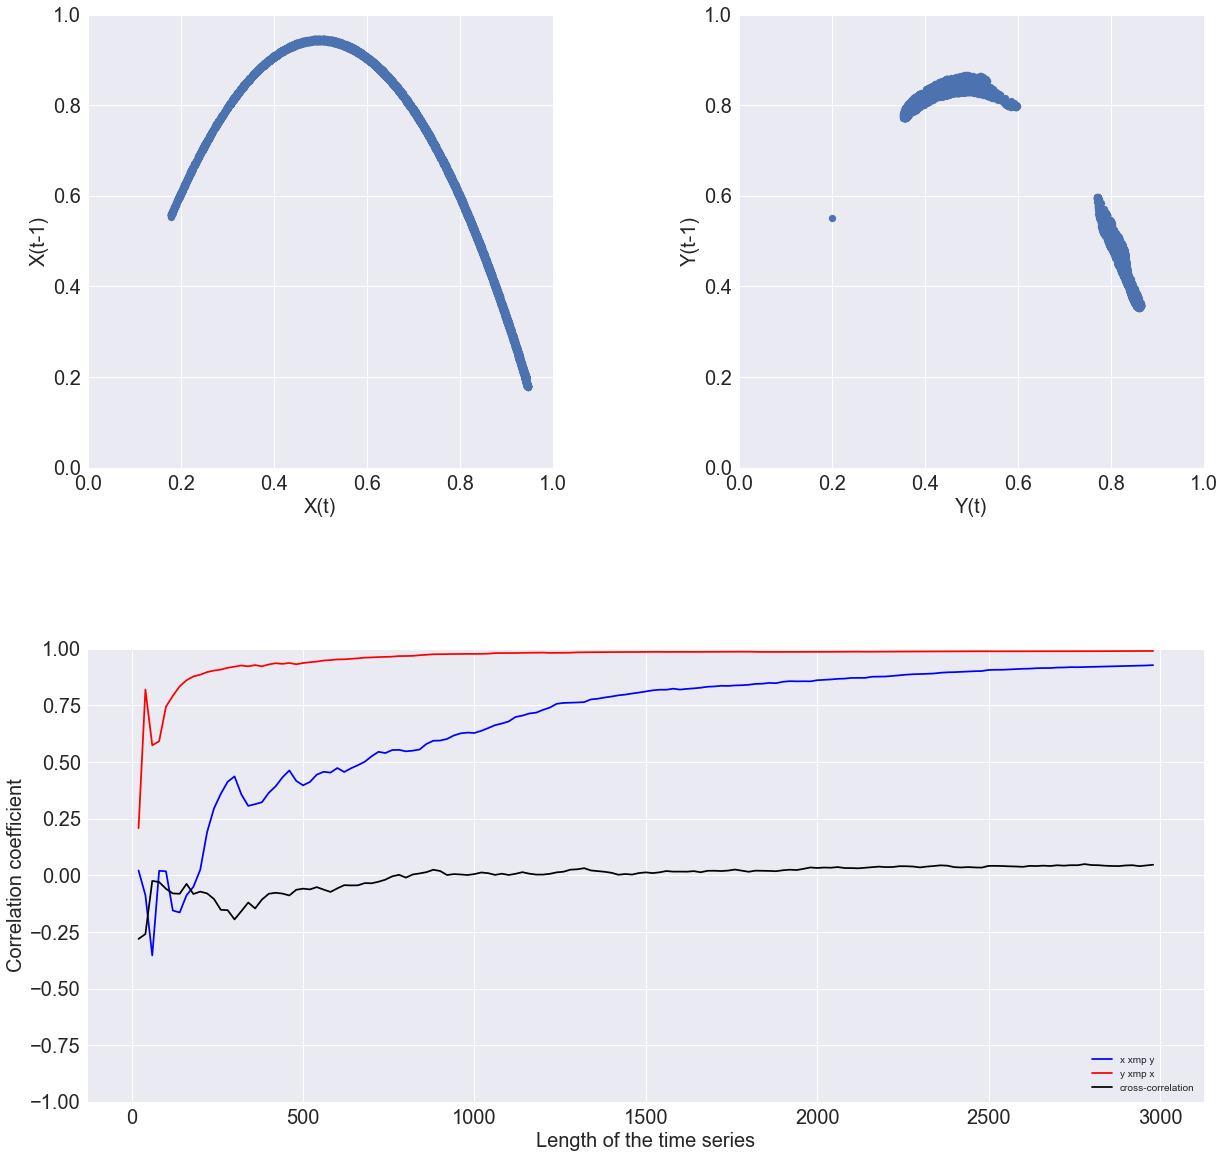

In [32]:
### The change of correlation coefficients versus time lengths
# Parameter settings
bxy, byx = .02, .1
rx, ry = 3.8, 3.5
x0, y0 = .4, .2
# x0 = .35 + .1*np.random.rand()
# y0 = .15 + .1 *np.random.rand()
L      = 3000
tau, E = 1, 2
L_set = range(20, L, 20)

# Compute rho for different lengths of the time series
xmpy, ympx = [], []
rhoset = []
for l in L_set:
    # Simulation
    x_set, y_set = two_species_logistic(x0, y0, l+l, rx, ry, bxy, byx)
    x, y = x_set[:l], y_set[:l]
    x_future, y_future = x_set[:l], y_set[:l]
    _, rho1 = ccm(x, y, x_future, y_future, E, tau)
    _, rho2 = ccm(y, x, y_future, x_future, E, tau)
    rhoset.append(np.corrcoef(x, y)[0,1])
    xmpy.append(rho1)
    ympx.append(rho2)

# Plot
plot_ccm.plot_ccm_with_trajectory(x_set, y_set, 1,
                                 L_set, xmpy, ympx, rhoset)
plt.show()

### 1.2 Contour plots of CCM skill in terms of different $b_{xy}$ and $b_{yz}$

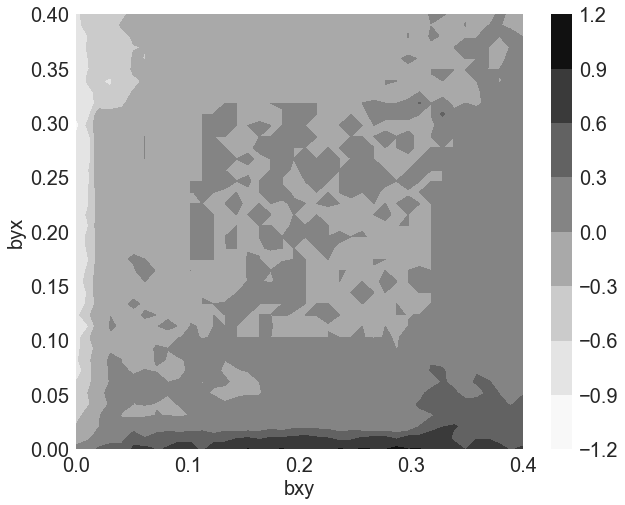

In [33]:
### The change of correlation coefficients in terms of different bxy and byx
# Parameter settings
bxy_set = np.linspace(0, .4, 40)
byx_set = np.linspace(0, .4, 40)
rx, ry  = 3.7, 3.7
L       = 400
L_future = 1000
n_bxy, n_byx = bxy_set.size, byx_set.size

xmpy = np.zeros([n_bxy, n_byx])
ympx = np.zeros([n_bxy, n_byx])

# CCM
for i in range(n_bxy):
    for j in range(n_byx):
        bxy, byx = bxy_set[i], byx_set[j]
        x_set, y_set = two_species_logistic(x0, y0, L+L_future, rx, ry, bxy, byx)
        x,     y     = x_set[:L], y_set[:L]
        x_future, y_future = x_set[L:], y_set[L:]
        _, rho1 = ccm(x, y, x_future, y_future, E, tau)
        _, rho2 = ccm(y, x, y_future, x_future ,E, tau)
        xmpy[i, j] = rho1
        ympx[i, j] = rho2

# Plot
plt.rcParams["figure.figsize"] = (10, 8)
xv, yv = np.meshgrid(bxy_set, byx_set, indexing='ij')

plt.contourf(xv, yv, xmpy-ympx)
plt.colorbar()
plt.xlabel('bxy')
plt.ylabel('byx')
plt.show()

### 1.3 When $b_{xy} = 0$, the CCM skills of $x -> y$ and $y -> x$

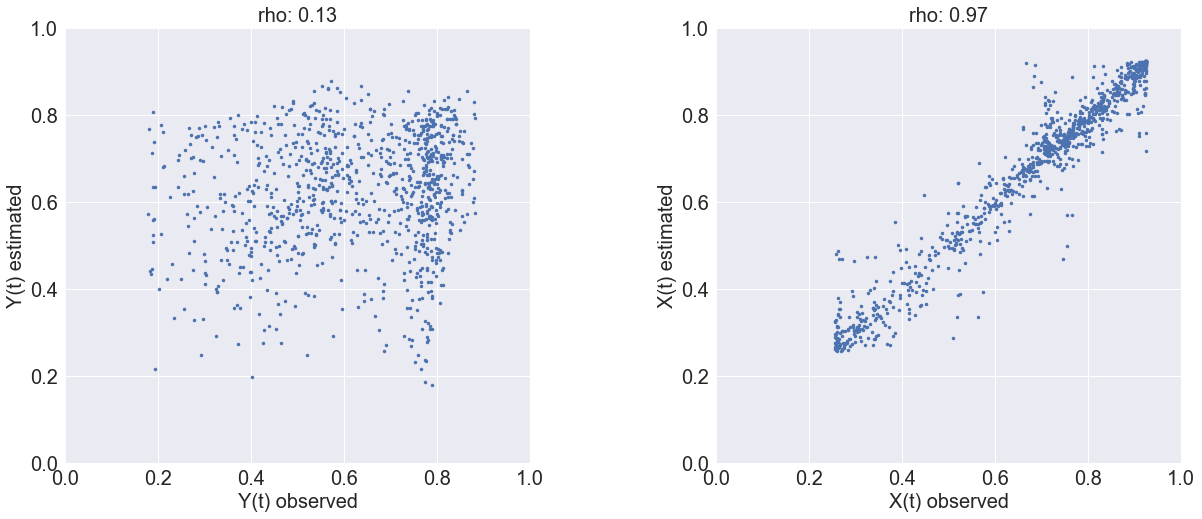

In [34]:
### when bxy =0
bxy, byx = 0, .32
rx, ry = 3.7, 3.7
x0, y0 = .2, .4
L = 1000
L_future = 1000
E, tau = 2, 1
x_set, y_set = two_species_logistic(x0, y0, L+L_future, rx, ry, bxy, byx)
x,     y     = x_set[:L], y_set[:L]
x_future, y_future = x_set[L:], y_set[L:]
y_est, rho1 = ccm(x, y, x_future, y_future, E, tau)
x_est, rho2 = ccm(y, x, y_future, x_future, E, tau)

# Plot
plot_ccm.plot_ccm_est_obs_xy(x_future[tau*(E-1):], x_est, 
                             y_future[tau*(E-1):], y_est,
                             rho2, rho1)
plt.show()

### 1.4 When $b_{xy} = 0$, the 3D plots of the CCM skills for different $b_{xy}$

In [35]:
### when bxy =0
rx, ry = 3.8, 3.5
x0, y0 = .4, .2
tau, E = 1, 2
L_set = np.arange(50, 2100, 100)
L_future = 1000
byx_set = np.linspace(0, 1.5, 40)
bxy = 0

xmpy = np.zeros([byx_set.size, L_set.size])
ympx = np.zeros([byx_set.size, L_set.size])

for j in range(L_set.size):
    for i in range(byx_set.size):
        byx, L = byx_set[i], L_set[j]
        x_set, y_set = two_species_logistic(x0, y0, L+L_future, rx, ry, bxy, byx)
        x,     y     = x_set[:L], y_set[:L]
        x_future, y_future = x_set[L:], y_set[L:]
        _, rho1 = ccm(x, y, x_future, y_future, E, tau)
        _, rho2 = ccm(y, x, y_future, x_future, E, tau)
        xmpy[i, j] = rho1
        ympx[i, j] = rho2

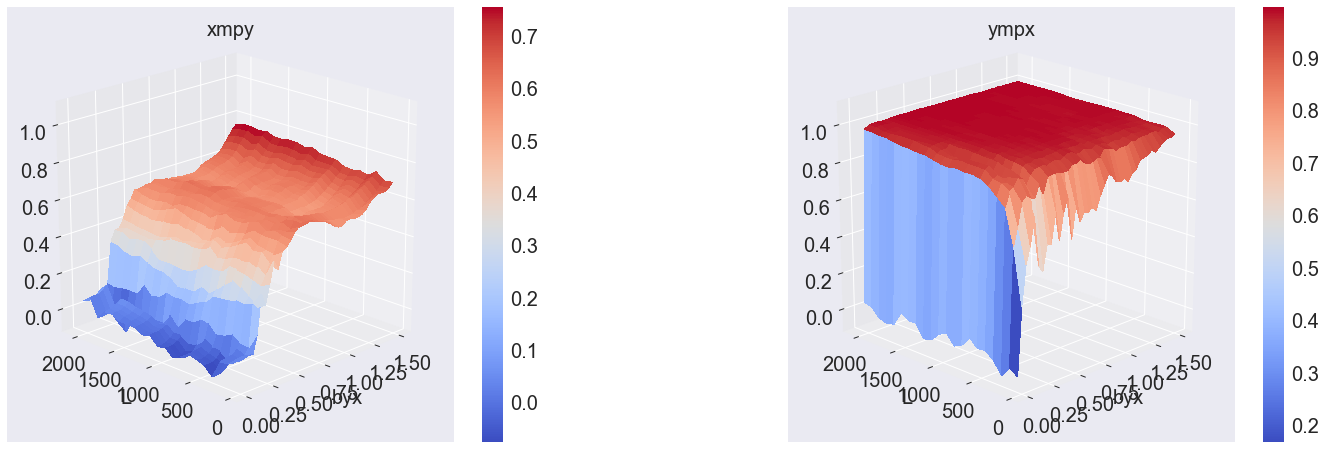

In [36]:
# Plot
xv, yv = np.meshgrid(byx_set, L_set, indexing='ij')
plot_ccm.plot_ccm_3d_xy(xmpy, ympx, xv, yv, 'byx', 'L')
plt.show()

### 1.5 Results of the extended CCM

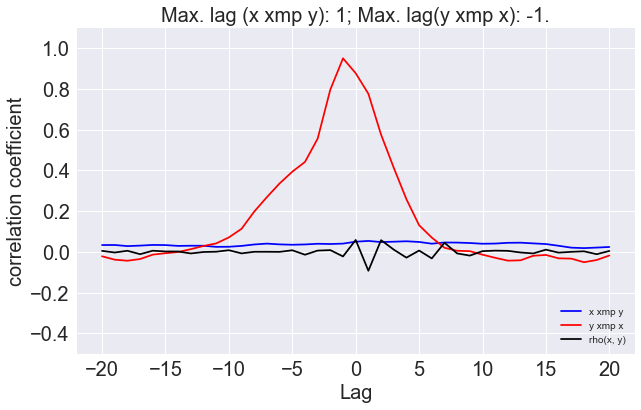

In [37]:
### Extended CCM
# Parameter settings
lagmax = 20
rx, ry = 3.8, 3.5
bxy, byx = 0.0, .1
x0, y0 = .4, .2
L = 2000
L_future = 500
E, tau = 2, 1
nsample = 15

# Simulate the model
x_set, y_set = two_species_logistic(x0, y0, L+L_future, rx, ry, bxy, byx)
x, y = x_set[200:2000], y_set[200:2000]
x_future, y_future = x_set[L:], y_set[L:]
randint = np.random.randint(200, 1500, nsample)

# Conduct the extended CCM
rhoxmpy_m = np.zeros(2*lagmax+1)
rhoympx_m = np.zeros(2*lagmax+1)
rhoxy_m   = np.zeros(2*lagmax+1)
for i in range(nsample):
    rint = randint[i]
    x, y = x_set[rint:rint+200], y_set[rint:rint+200]
    lagset, rhoxmpy, rhoympx = extended_ccm(x, y, x_future, y_future, E, lagmax, tau)
    rhoxy = corrcoefs(x_set, y_set, lagset)
    rhoxmpy_m += rhoxmpy
    rhoympx_m += rhoympx
    rhoxy_m   += rhoxy

rhoxmpy_m = rhoxmpy_m / nsample
rhoympx_m = rhoympx_m / nsample
rhoxy_m   = rhoxy_m / nsample

# Plot
plot_ccm.plot_extended_ccm_xy(lagset, rhoxmpy_m, rhoympx_m, rhoxy_m)
plt.show()

# 2. The two coupled logistic equations with delayed
\begin{aligned}
x(t+1) &= x(t)[r_x-r_x x(t)-b_{xy}y(t)] \\
y(t+1) &= y(t)[r_y-r_y y(t)-b_{yx}x(t-\tau_d)]
\end{aligned}

In [38]:
# Function for a coupled two-species nonlienar logistic difference system with chaotic dynamics
def two_species_logistic_delayed(x0, y0, N, rx, ry, bxy, byx, tau):
    x_set = np.zeros(N)
    y_set = np.zeros(N)
    x_set[0:tau+1] = x0
    y_set[0:tau+1] = y0
    
    for i in range(N-1-tau):
        x_set[i+1+tau] = x_set[i+tau]*(rx-rx*x_set[i+tau]-bxy*y_set[i+tau])
        y_set[i+1+tau] = y_set[i+tau]*(ry-ry*y_set[i+tau]-byx*x_set[i])
    
    return x_set, y_set

### 2.1 The results of the extended CCM
$r_x=3.8, r_y=3.8, b_{xy}=0.07, b_{yx}=0.08, \tau_d=4$

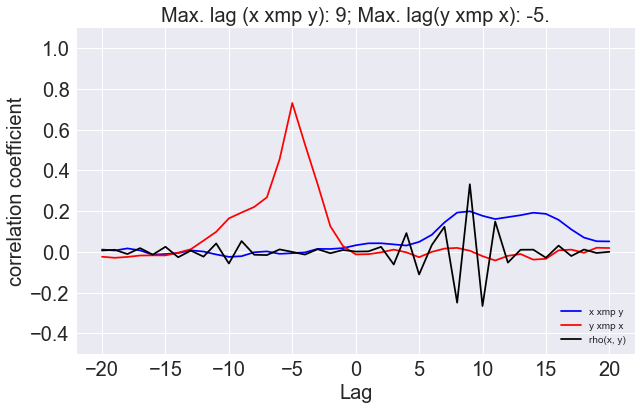

In [39]:
### Extended CCM
# Parameter settings
lagmax = 20
rx, ry = 3.8, 3.8
bxy, byx = .0, 0.1
x0, y0 = .2, .4
L = 2000
L_future = 500
E, tau = 2, 1
tauspe = 4
nsample = 15

# Simulate the model
x_set, y_set = two_species_logistic_delayed(x0, y0, L+L_future, rx, ry, bxy, byx, tauspe)
x, y = x_set[200:L], y_set[200:L]
x_future, y_future = x_set[L:], y_set[L:]
randint = np.random.randint(200, 1500, nsample)

# Conduct the extended CCM
rhoxmpy_m = np.zeros(2*lagmax+1)
rhoympx_m = np.zeros(2*lagmax+1)
rhoxy_m   = np.zeros(2*lagmax+1)
for i in range(nsample):
    rint = randint[i]
    x, y = x_set[rint:rint+200], y_set[rint:rint+200]
    lagset, rhoxmpy, rhoympx = extended_ccm(x, y, x_future, y_future, E, lagmax, tau)
    rhoxy = corrcoefs(x_set, y_set, lagset)
    rhoxmpy_m += rhoxmpy
    rhoympx_m += rhoympx
    rhoxy_m   += rhoxy

rhoxmpy_m = rhoxmpy_m / nsample
rhoympx_m = rhoympx_m / nsample
rhoxy_m = rhoxy_m / nsample

# Plot
plot_ccm.plot_extended_ccm_xy(lagset, rhoxmpy_m, rhoympx_m, rhoxy_m)
plt.show()

# 3. Coupled chaotic logistic networks (3-nodes case)

### 3.1 Case1 -- unconnected network driven by individual chaotic logistic equations
\begin{aligned}
x(t+1) &= x(t)[1-x(t)] \\
y(t+1) &= y(t)[1-y(t)] \\
z(t+1) &= z(t)[1-z(t)] 
\end{aligned}

It is obvious from the causality result that x, y and z do not affect each other.

In [40]:
# Parameters for the relationship between variables
n    = 3
lag  = 1
adjM = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
lagM = np.array([[lag, 0, 0], [0, lag, 0], [0, 0, lag]])
# Parameters for simulation
nstep_l = 1000
nstep_f = 1000
noiseOn = [0, 0, 0]
noiseDist = 'uniform'
noisePara = [1, 0, 1]
# Parameters for CCM
E, tau = 2, 1
tauspe = 4
lagmax = 20
# Generate the simulation
logistics = Logistic(n, adjM, lagM, noiseOn=noiseOn, noiseDist=noiseDist, noisePara=noisePara)
results = logistics.simulate(nstep_l+nstep_f)
x, y, z = results[0,: ], results[1, :], results[2, :]
# Calcualte the extended CCM for (x and y), (y and z) and (x and z)
lagset, rhoxmpy, rhoympx = extended_ccm(x[:nstep_l], y[:nstep_l], x[nstep_l:], y[nstep_l:], E, lagmax, tau)
lagset, rhoympz, rhozmpy = extended_ccm(y[:nstep_l], z[:nstep_l], y[nstep_l:], z[nstep_l:], E, lagmax, tau)
lagset, rhoxmpz, rhozmpx = extended_ccm(x[:nstep_l], z[:nstep_l], x[nstep_l:], z[nstep_l:], E, lagmax, tau)
# Calculate the correlation coefficients
rhoxy = corrcoefs(x, y, lagset)
rhoyz = corrcoefs(y, z, lagset)
rhoxz = corrcoefs(x, z, lagset)
# Conduct SST on MI
lagset, mirxy, mixy = conductSST_withlag(x, y, lagmax, returnTrue=True)
lagset, mirxz, mixz = conductSST_withlag(x, z, lagmax, returnTrue=True)
lagset, miryz, miyz = conductSST_withlag(y, z, lagmax, returnTrue=True)

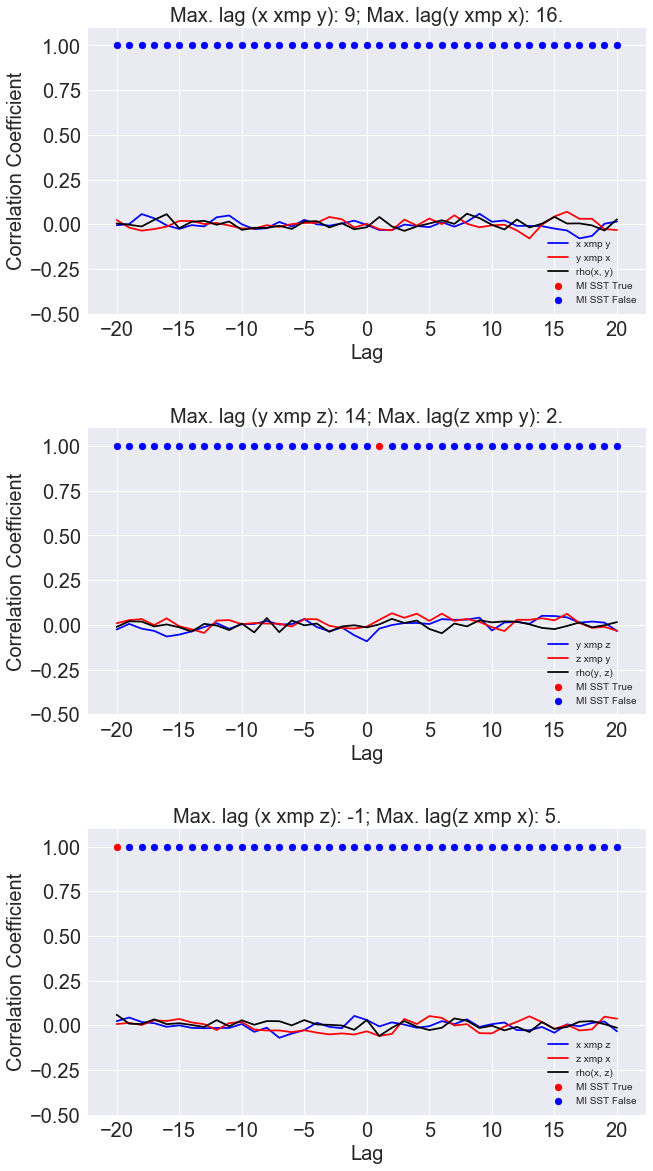

In [41]:
# Plots
plot_ccm.plot_extended_ccm_3d_withmi(lagset, rhoxmpy, rhoympx, rhoympz, rhozmpy, 
                                     rhoxmpz, rhozmpx, rhoxy, rhoyz, rhoxz,
                                     mirxy, mirxz, miryz)
plt.show()

### 3.2 Case2
\begin{aligned}
x(t+1) &= \frac{1}{2} \{x(t)[1-x(t)] + z(t)[1-z(t)]\}\\
y(t+1) &= \frac{1}{2} \{y(t)[1-y(t)] + z(t)[1-z(t)]\}\\
z(t+1) &= N(0, 1) 
\end{aligned}

It can be observed that x[t+1] -> z[t] and y[t+1] -> z[t]. Since there is no way that the future can affect the past, what it really implies is z[t] -> x[t-1] and z[t] -> x[t-1].

Also, it should be noted that even though x and y do not have impacts each other, they are still be able to 'influence' each other with lags 0 and 1. This 'fake' causality is due to their common driver z. In fact, x is a function of y and y is also a function of x if we replace z with x and y's formula.

In [42]:
# Parameters for the relationship between variables
n    = 3
lag  = 1
adjM = np.array([[1, 0, 1], [0, 1, 1], [0, 0, 0]])
lagM = np.array([[lag, 0, lag], [0, lag, lag], [0, 0, 0]])
# Parameters for simulation
nstep_l = 1000
nstep_f = 1000
noiseOn = [0, 0, 1]
noiseDist = 'uniform'
noisePara = [1, 0, 1]
# Parameters for CCM
E, tau = 2, 1
tauspe = 4
lagmax = 20
# Generate the simulation
logistics = Logistic(n, adjM, lagM, noiseOn=noiseOn, noiseDist=noiseDist, noisePara=noisePara)
results = logistics.simulate(nstep_l+nstep_f)
x, y, z = results[0,: ], results[1, :], results[2, :]
# Calcualte the extended CCM for (x and y), (y and z) and (x and z)
lagset, rhoxmpy, rhoympx = extended_ccm(x[:nstep_l], y[:nstep_l], x[nstep_l:], y[nstep_l:], E, lagmax, tau)
lagset, rhoympz, rhozmpy = extended_ccm(y[:nstep_l], z[:nstep_l], y[nstep_l:], z[nstep_l:], E, lagmax, tau)
lagset, rhoxmpz, rhozmpx = extended_ccm(x[:nstep_l], z[:nstep_l], x[nstep_l:], z[nstep_l:], E, lagmax, tau)
# Calculate the correlation coefficients
rhoxy = corrcoefs(x, y, lagset)
rhoyz = corrcoefs(y, z, lagset)
rhoxz = corrcoefs(x, z, lagset)
# Conduct SST on MI
lagset, mirxy, mixy = conductSST_withlag(x, y, lagmax, returnTrue=True)
lagset, mirxz, mixz = conductSST_withlag(x, z, lagmax, returnTrue=True)
lagset, miryz, miyz = conductSST_withlag(y, z, lagmax, returnTrue=True)

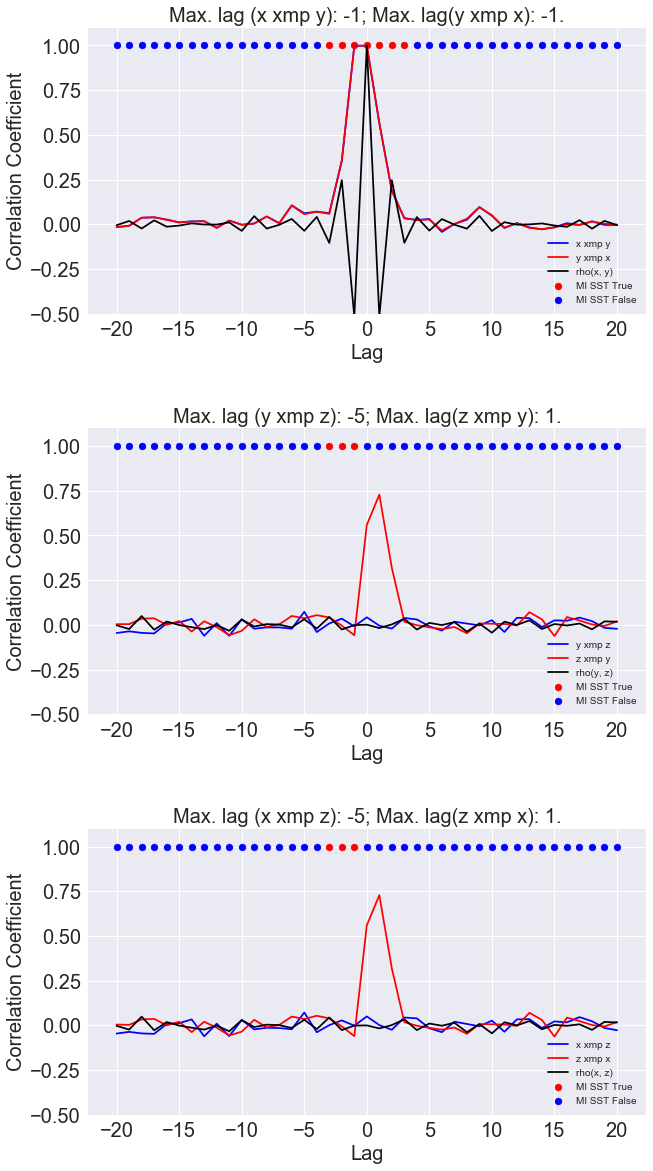

In [43]:
# Plots
plot_ccm.plot_extended_ccm_3d_withmi(lagset, rhoxmpy, rhoympx, rhoympz, rhozmpy, 
                                     rhoxmpz, rhozmpx, rhoxy, rhoyz, rhoxz,
                                     mirxy, mirxz, miryz)
plt.show()

### 3.3 Case3
\begin{aligned}
x(t+1) &= N(0, 1) + z(t)[1-z(t)]\\
y(t+1) &= N(0, 1) + z(t)[1-z(t)]\\
z(t+1) &= N(0, 1) 
\end{aligned}

In [44]:
# Parameters for the relationship between variables
n    = 3
lag  = 1
adjM = np.array([[0, 0, 1], [0, 0, 1], [0, 0, 0]])
lagM = np.array([[0, 0, lag], [0, 0, lag], [0, 0, 0]])
# Parameters for simulation
nstep_l = 1000
nstep_f = 1000
noiseOn = [1, 1, 1]
noiseDist = 'uniform'
noisePara = [1, 0, 1]
# Parameters for CCM
E, tau = 2, 1
tauspe = 4
lagmax = 20
# Generate the simulation
logistics = Logistic(n, adjM, lagM, noiseOn=noiseOn, noiseDist=noiseDist, noisePara=noisePara)
results = logistics.simulate(nstep_l+nstep_f)
x, y, z = results[0,: ], results[1, :], results[2, :]
# Calcualte the extended CCM for (x and y), (y and z) and (x and z)
lagset, rhoxmpy, rhoympx = extended_ccm(x[:nstep_l], y[:nstep_l], x[nstep_l:], y[nstep_l:], E, lagmax, tau)
lagset, rhoympz, rhozmpy = extended_ccm(y[:nstep_l], z[:nstep_l], y[nstep_l:], z[nstep_l:], E, lagmax, tau)
lagset, rhoxmpz, rhozmpx = extended_ccm(x[:nstep_l], z[:nstep_l], x[nstep_l:], z[nstep_l:], E, lagmax, tau)
# Calculate the correlation coefficients
rhoxy = corrcoefs(x, y, lagset)
rhoyz = corrcoefs(y, z, lagset)
rhoxz = corrcoefs(x, z, lagset)
# Conduct SST on MI
lagset, mirxy, mixy = conductSST_withlag(x, y, lagmax, returnTrue=True)
lagset, mirxz, mixz = conductSST_withlag(x, z, lagmax, returnTrue=True)
lagset, miryz, miyz = conductSST_withlag(y, z, lagmax, returnTrue=True)

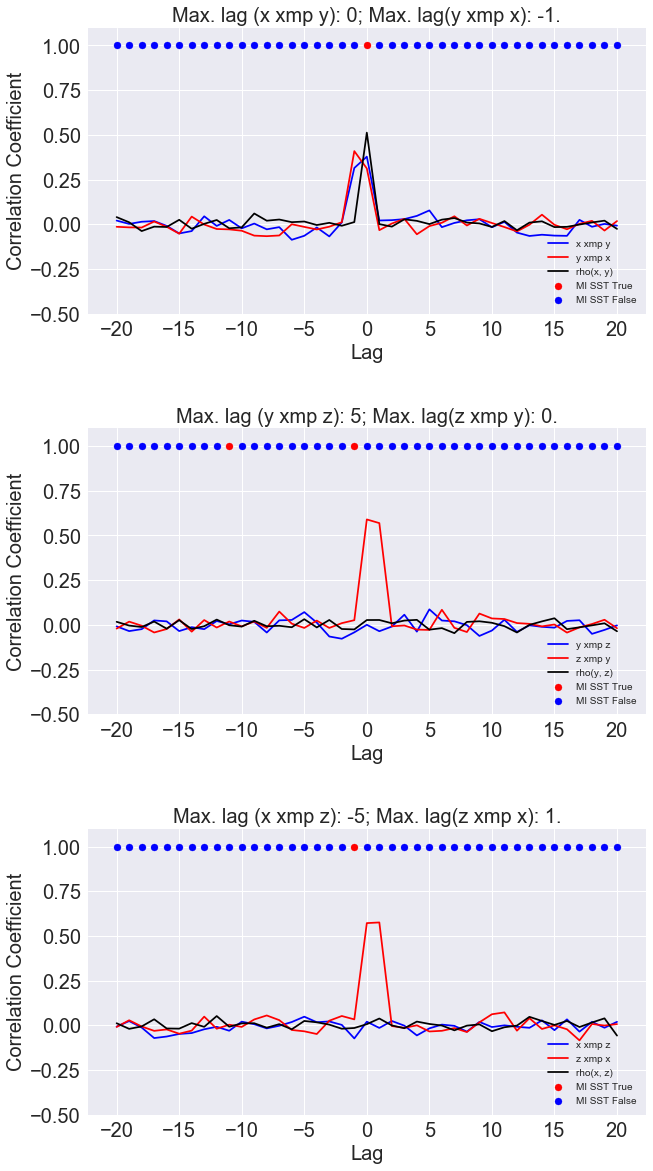

In [45]:
# Plots
plot_ccm.plot_extended_ccm_3d_withmi(lagset, rhoxmpy, rhoympx, rhoympz, rhozmpy, 
                                     rhoxmpz, rhozmpx, rhoxy, rhoyz, rhoxz,
                                     mirxy, mirxz, miryz)
plt.show()

### 3.4 Case4
\begin{aligned}
x(t+1) &= \frac{1}{2} \{x(t)[1-x(t)] + z(t)[1-z(t)]\}\\
y(t+1) &= \frac{1}{2} \{y(t)[1-y(t)] + z(t)[1-z(t)]\}\\
z(t+1) &= \frac{1}{2} \{x(t)[1-x(t)] + y(t)[1-y(t)]\}
\end{aligned}

In [46]:
# Parameters for the relationship between variables
n    = 3
lag  = 1
adjM = np.array([[1, 0, 1], [0, 1, 1], [1, 1, 0]])
lagM = np.array([[lag, 0, lag], [0, lag, lag], [lag, lag, 0]])
# Parameters for simulation
nstep_l = 1000
nstep_f = 1000
noiseOn = [0, 0, 0]
noiseDist = 'uniform'
noisePara = [1, 0, 1]
# Parameters for CCM
E, tau = 2, 1
tauspe = 4
lagmax = 20
# Generate the simulation
logistics = Logistic(n, adjM, lagM, noiseOn=noiseOn, noiseDist=noiseDist, noisePara=noisePara)
results = logistics.simulate(nstep_l+nstep_f)
x, y, z = results[0,: ], results[1, :], results[2, :]
# Calcualte the extended CCM for (x and y), (y and z) and (x and z)
lagset, rhoxmpy, rhoympx = extended_ccm(x[:nstep_l], y[:nstep_l], x[nstep_l:], y[nstep_l:], E, lagmax, tau)
lagset, rhoympz, rhozmpy = extended_ccm(y[:nstep_l], z[:nstep_l], y[nstep_l:], z[nstep_l:], E, lagmax, tau)
lagset, rhoxmpz, rhozmpx = extended_ccm(x[:nstep_l], z[:nstep_l], x[nstep_l:], z[nstep_l:], E, lagmax, tau)
# Calculate the correlation coefficients
rhoxy = corrcoefs(x, y, lagset)
rhoyz = corrcoefs(y, z, lagset)
rhoxz = corrcoefs(x, z, lagset)
# Conduct SST on MI
lagset, mirxy, mixy = conductSST_withlag(x, y, lagmax, returnTrue=True)
lagset, mirxz, mixz = conductSST_withlag(x, z, lagmax, returnTrue=True)
lagset, miryz, miyz = conductSST_withlag(y, z, lagmax, returnTrue=True)

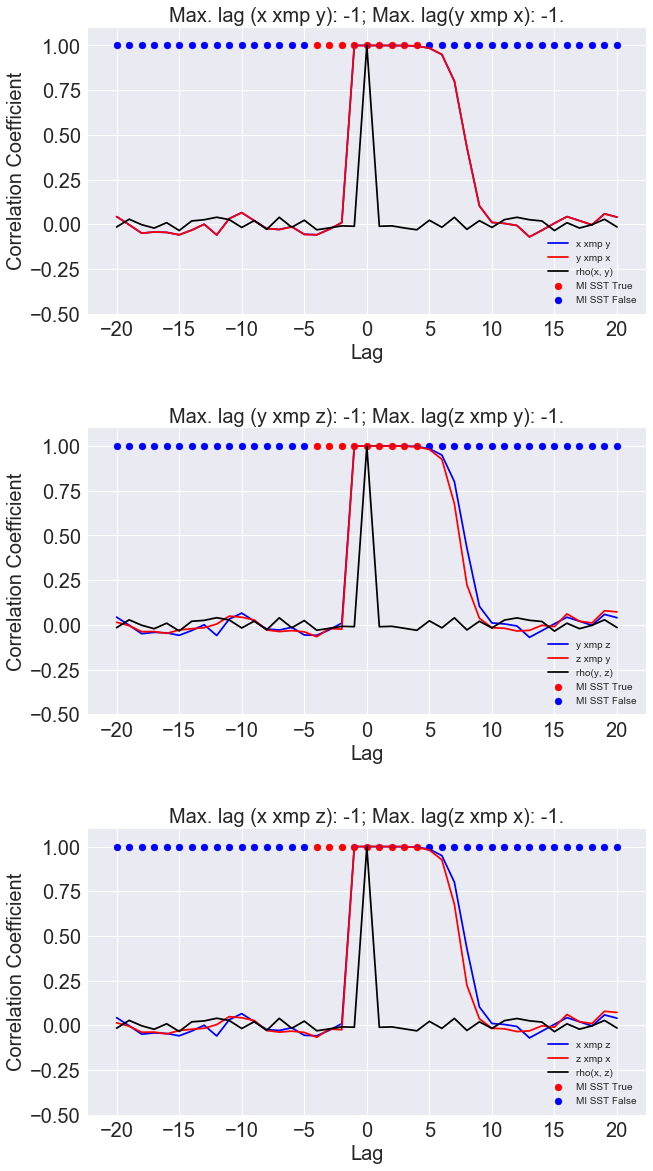

In [ ]:
# Plots
plot_ccm.plot_extended_ccm_3d_withmi(lagset, rhoxmpy, rhoympx, rhoympz, rhozmpy, 
                                     rhoxmpz, rhozmpx, rhoxy, rhoyz, rhoxz,
                                     mirxy, mirxz, miryz)
plt.show()

### 3.5 Case5 -- a standard fishery model system
\begin{aligned}
Z        &= N(0, 1) \\
R_x(t+1) &= X(t) [3.1(1-X(t))] \exp(-0.3Z) \\
R_y(t+1) &= Y(t) [2.9(1-Y(t))] \exp(-0.36Z) \\
X(t+1)   &= 0.4X(t)+\max(R_x(t-3), 0) \\
Y(t+1)   &= 0.4Y(t)+\max(R_y(t-3), 0)
\end{aligned}

In [ ]:
# Parameters for simulation
nstep_l = 1000
nstep_f = 1000
# Parameters for CCM
E, tau = 4, 1
lagmax = 20
# Simulation
x, y, z = fishery_model(nstep_l+nstep_f)
# Calculate the extended CCM for (x and y), (y and z) and (x and z)
lagset, rhoxmpy, rhoympx = extended_ccm(x[:nstep_l], y[:nstep_l], x[nstep_l:], y[nstep_l:], E, lagmax, tau)
lagset, rhoympz, rhozmpy = extended_ccm(y[:nstep_l], z[:nstep_l], y[nstep_l:], z[nstep_l:], E, lagmax, tau)
lagset, rhoxmpz, rhozmpx = extended_ccm(x[:nstep_l], z[:nstep_l], x[nstep_l:], z[nstep_l:], E, lagmax, tau)
# Calculate the correlation coefficients
rhoxy = corrcoefs(x, y, lagset)
rhoyz = corrcoefs(y, z, lagset)
rhoxz = corrcoefs(x, z, lagset)
# Conduct SST on MI
lagset, mirxy, mixy = conductSST_withlag(x, y, lagmax, returnTrue=True)
lagset, mirxz, mixz = conductSST_withlag(x, z, lagmax, returnTrue=True)
lagset, miryz, miyz = conductSST_withlag(y, z, lagmax, returnTrue=True)

/Users/Ben1897/Documents/research/code/info/info/core/info.py:181: RuntimeWarning: invalid value encountered in divide
  ypdfs_x_log, ypdfs_x = np.ma.log(xypdfs/xpdfs), np.ma.divide(xypdfs, xpdfs)
/Users/Ben1897/Documents/research/code/info/info/core/info.py:211: RuntimeWarning: invalid value encountered in divide
  ixypdf_log = np.ma.log(pdfs/(xpdfs*ypdfs))


In [ ]:
# Plots
plot_ccm.plot_extended_ccm_3d_withmi(lagset, rhoxmpy, rhoympx, rhoympz, rhozmpy, 
                                     rhoxmpz, rhozmpx, rhoxy, rhoyz, rhoxz,
                                     mirxy, mirxz, miryz)
plt.show()

In [ ]:
# ### Load data and compute the xmpy and ympx
# data = np.genfromtxt('data1.txt')
# x_set, y_set = data[:,0], data[:,1]
# tau1, E = 1, 4
# L_set = np.arange(100, 1100, 100)

# # Compute rho for different lengths of the time series
# xmpy, ympx = [], []
# for l in L_set:
#     x, y = x_set[:l/2], y_set[:l/2]
#     x_future, y_future = x_set[l/2:], y_set[l/2:]
#     _, rho1 = ccm(x, y, x_future, y_future, E, tau, filtered=False)
#     _, rho2 = ccm(y, x, y_future, x_future, E, tau, filtered=False)
#     xmpy.append(rho1)
#     ympx.append(rho2)
    
# plt.rcParams["figure.figsize"] = (10,8)
# plt.plot(L_set, xmpy, 'b', label='x xmp y')
# plt.plot(L_set, ympx, 'r', label='y xmp x')
# plt.xlabel('Length of the time series')
# plt.ylabel('Correlation coefficient')
# plt.ylim([-1, 1])
# plt.xlim([0, l])
# plt.legend(loc='lower right')

# plt.show()

# ### The change of correlation coefficients versus time lengths
# # Parameter settings
# rx, ry = 3.8, 3.1
# bxy, byx = 0.0, .8
# x0, y0 = .2, .4
# L      = 2000
# L_future = 1000
# lag = 10
# tau, E = 1, 2

# # Simulation
# x_set, y_set = two_species_logistic(x0, y0, L+L_future, rx, ry, bxy, byx)
# if lag > 0:
#     x,     y     = x_set[:L-lag], y_set[lag:L]
#     x_future, y_future = x_set[L:-lag], y_set[lag+L:]
# elif lag < 0:
#     x,     y     = x_set[-lag:L], y_set[:L+lag]
#     x_future, y_future = x_set[-lag+L:], y_set[L:lag]
# else:
#     x,     y     = x_set[:L], y_set[:L]
#     x_future, y_future = x_set[L:], y_set[L:]
    
# xmpy, rho1 = ccm(x, y, x_future, y_future, E, tau, filtered=False)
# ympx, rho2 = ccm(y, x, y_future, x_future, E, tau, filtered=False)